In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import math
import json
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import networkx
from matplotlib import pyplot

In [3]:
from models import get_model
from toolbox.losses import mcp_loss
from toolbox import metrics, utils
from loaders.data_generator import MCP_Generator
from loaders.siamese_loaders import siamese_loader
from toolbox.metrics import all_losses_acc, accuracy_linear_assignment

In [112]:
n_vertices = 100
a = 0.2
edge_density = 1/(n_vertices **a)

In [113]:
edge_density

0.39810717055349726

In [114]:
2/a+2*np.log(a)/(a*np.log(n_vertices))+2*np.log(np.exp(1)/2)/(a*np.log(n_vertices))+1

8.171472409516259

In [51]:
clique_size = 15
args= {}
args['edge_density'] = edge_density
args['clique_size'] = clique_size
args['num_examples_test'] = 200
args['n_vertices'] = n_vertices
args['path_dataset'] = './dataset_mcp'

In [52]:
gen= MCP_Generator('test',args)

In [53]:
gen.load_dataset()

Reading dataset at ./dataset_mcp/MCP_200_100_15_0.1/test.pkl


In [54]:
def get_device_config(model_path):
    config_file = os.path.join(model_path,'config.json')
    with open(config_file) as json_file:
        config_model = json.load(json_file)
    use_cuda = not config_model['cpu'] and torch.cuda.is_available()
    device = 'cuda' if use_cuda else 'cpu'
    return config_model, device

def load_model(model_path, config, device):
    model = get_model(config['arch'])
    model.to(device)
    model_file = os.path.join(model_path,'model_best.pth.tar')
    checkpoint = torch.load(model_file)
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [55]:
arch = {} # Architecture and model
    
arch['arch']= 'Simple_Node_Embedding'
arch['model_name'] = 'Simple_Node_Embedding'
arch['num_blocks'] = 4
arch['original_features_num'] = 2
arch['in_features'] = 64
arch['out_features'] = 1
arch['depth_of_mlp'] = 3


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [56]:
weight = torch.ones((n_vertices,n_vertices))
weight[:clique_size,:clique_size] = (n_vertices**2-clique_size**2)/clique_size**2 * torch.ones((clique_size,clique_size))
weight= weight.to(device)
mcp_loss = torch.nn.BCELoss(weight=weight,reduction='mean')
weight = torch.ones(n_vertices)
weight[:clique_size] = (n_vertices-clique_size)/clique_size*torch.ones(clique_size)
weight = weight.to(device)
mcp_loss = torch.nn.BCELoss(weight=weight,reduction='mean')

In [92]:
import trainer as trainer
train_loader = siamese_loader(gen, 16, gen.constant_n_vertices)
learning_rate = 1e-3

model = get_model(arch)
model.to(device);

Fetching model Simple_Node_Embedding - Simple_Node_Embedding 


In [93]:
optimizer = torch.optim.Adam(model.parameters(),
                            lr=learning_rate,
                            amsgrad=False)

In [94]:
rawscores.shape

torch.Size([8, 100])

In [95]:
labels = torch.diag(K[0,:,:,0])/(clique_size-1)

In [96]:
labels.unsqueeze_(0)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')

In [97]:
labels.shape

torch.Size([1, 100])

In [98]:
labels.expand(16,-1).shape

torch.Size([16, 100])

In [99]:
proba.shape

torch.Size([8, 100])

In [101]:
for i in range(10):
    for G, K in train_loader:
        G = G.to(device)
        K = K.to(device)
        output = model(G)
        rawscores = output.squeeze(-1)
        bs = rawscores.shape[0]
        #proba = nn.Softmax(2)(rawscores.view(bs, 1, -1)).view_as(rawscores)
        #proba = torch.softmax(rawscores,-1)
        #loss = mcp_loss(proba,K[:,:,:,1])
        proba = torch.sigmoid(rawscores)
        loss = mcp_loss(proba,labels.expand(bs,-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(i,loss.item())

0 1.1792024374008179
1 1.1790193319320679
2 1.1788707971572876
3 1.1787512302398682
4 1.1786561012268066
5 1.1785813570022583
6 1.178523063659668
7 1.1784782409667969
8 1.1784441471099854
9 1.1784182786941528


In [162]:
torch.sum(proba[5,:,:],0)

IndexError: too many indices for tensor of dimension 2

In [75]:
torch.sum(proba[5,:,:],1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)

In [40]:
optimizer = torch.optim.Adam(model.parameters(),
                            lr=1e-5,
                            amsgrad=False)

In [102]:
for i in range(10):
    for G, K in train_loader:
        G = G.to(device)
        K = K.to(device)
        output = model(G)
        rawscores = output.squeeze(-1)
        bs = rawscores.shape[0]
        #proba = nn.Softmax(2)(rawscores.view(bs, 1, -1)).view_as(rawscores)
        #proba = torch.softmax(rawscores,-1)
        #loss = mcp_loss(proba,K[:,:,:,1])
        proba = torch.sigmoid(rawscores)
        loss = mcp_loss(proba,labels.expand(bs,-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(i,loss.item())

0 1.1783989667892456
1 1.178384780883789
2 1.1783746480941772
3 1.1783671379089355
4 1.1783618927001953
5 1.1783580780029297
6 1.1783555746078491
7 1.1783536672592163
8 1.1783524751663208
9 1.1783517599105835


In [103]:
rawscores[5,:]

tensor([0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027,
        0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027,
        0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027,
        0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027,
        0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027,
        0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027,
        0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027,
        0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027,
        0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027,
        0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027,
        0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027, 0.0027,
        0.0027], device='cuda:0', grad_fn=<SliceBackward>)

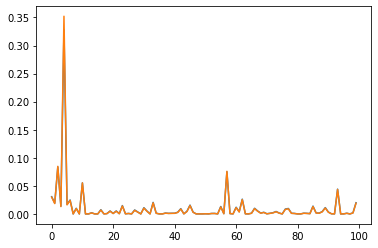

In [90]:
plt.plot(proba[5,20,:].cpu().detach().numpy());
plt.plot(proba[5,0,:].cpu().detach().numpy());

In [91]:
proba[5,3:8,:10]

tensor([[2.9532e-02, 1.8053e-02, 8.5391e-02, 1.2652e-02, 3.6384e-01, 1.5769e-02,
         2.3585e-02, 2.5874e-08, 9.0685e-03, 2.7840e-08],
        [3.0022e-02, 1.8568e-02, 8.4818e-02, 1.3157e-02, 3.4865e-01, 1.6255e-02,
         2.4100e-02, 3.6137e-08, 9.4861e-03, 3.8760e-08],
        [3.0491e-02, 1.9090e-02, 8.3777e-02, 1.3636e-02, 3.3297e-01, 1.6757e-02,
         2.4596e-02, 5.2328e-08, 9.9279e-03, 5.6072e-08],
        [3.0282e-02, 1.8844e-02, 8.4350e-02, 1.3398e-02, 3.4077e-01, 1.6521e-02,
         2.4309e-02, 4.3721e-08, 9.7025e-03, 4.6895e-08],
        [3.0965e-02, 1.9635e-02, 8.2766e-02, 1.4163e-02, 3.1588e-01, 1.7336e-02,
         2.5144e-02, 7.7040e-08, 1.0392e-02, 8.2530e-08]], device='cuda:0',
       grad_fn=<SliceBackward>)

In [69]:
rawscores[5,3:8,:10]

IndexError: too many indices for tensor of dimension 2

In [70]:
deg = torch.sum(proba[5,:,:],0)

IndexError: too many indices for tensor of dimension 2

In [104]:
 _, ind = torch.topk(proba[5,:] , clique_size)#torch.topk(deg, clique_size)

In [105]:
ind

tensor([ 7,  6,  4,  5,  1,  0,  2,  3, 11, 10,  8,  9, 13, 12, 14],
       device='cuda:0')

In [106]:
true_deg = torch.sum(G[5,:,:,1],1)

In [107]:
_, ind_n = torch.topk(true_deg, clique_size)

In [108]:
ind_n

tensor([ 7,  3, 13, 12,  6, 14,  2, 11,  1,  0,  5, 10,  8,  9,  4],
       device='cuda:0')

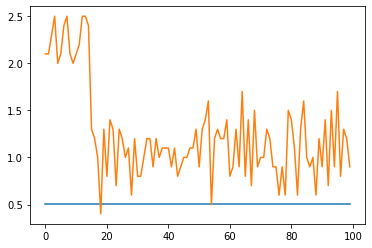

In [109]:
#plt.plot(deg.cpu().detach().numpy())
plt.plot(proba[5,:].cpu().detach().numpy())
plt.plot(true_deg.cpu().detach().numpy()/10)

TypeError: Invalid shape (100,) for image data

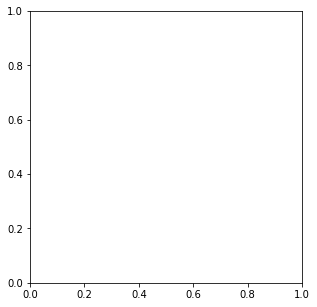

In [50]:
fig = pyplot.figure(figsize=(5, 5)) # in inches
pyplot.imshow(proba[5,:,:].cpu().detach().numpy(),
                  cmap="Greys",
                  interpolation="none")

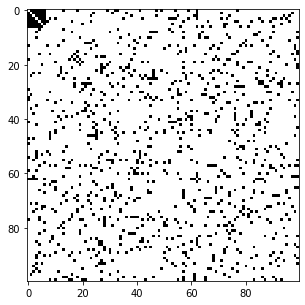

In [101]:
fig = pyplot.figure(figsize=(5, 5)) # in inches
pyplot.imshow(G[5,:,:,1].cpu().detach().numpy(),
                  cmap="Greys",
                  interpolation="none")

In [29]:
m = nn.Softmax2d()

In [30]:
input = torch.randn(2, 3, 12, 13)

In [31]:
output = m(input)

In [36]:
torch.sum(output[0,:,1,1])

tensor(1.)

In [173]:
K[5,:10,:10,1]

tensor([[0., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')

In [174]:
G[5,:10,:10,1]

tensor([[0., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 0., 1.],
        [1., 1., 1., 0., 1., 1., 0., 1., 1., 0.],
        [1., 1., 1., 1., 0., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')

In [71]:
preds = torch.stack((torch.max(output[:,:5,:],1)[0],torch.max(output[:,5:,:],1)[0]),1)
probas = torch.log_softmax(preds,1)

In [72]:
torch.max(output[:,:5,:],1)[0].shape

torch.Size([16, 100])

In [73]:
probas[0,:,1]

tensor([-12864.7617,      0.0000], device='cuda:0', grad_fn=<SelectBackward>)

In [74]:
probas.shape

torch.Size([16, 2, 100])

In [75]:
target = torch.zeros_like(probas[:,0,:],dtype=torch.long)

In [76]:

target[:,:5] = torch.ones((16,5),dtype=torch.long)

In [77]:
target.shape

torch.Size([16, 100])

In [78]:
target[0,:10]

tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')

In [79]:
l_fun(probas,target)

tensor(14757.9775, device='cuda:0', grad_fn=<NllLoss2DBackward>)

In [23]:
def accuracy_max_mcp(weights,clique_size):
    """
    weights should be (bs,n,n) and labels (bs,n) numpy arrays
    """
    acc = 0
    total_n_vertices = 0
    for i, weight in enumerate(weights):
        weight = weight.cpu().detach().numpy()
        preds = np.argmax(weight, 1)
        #print(preds)
        acc += np.sum(preds[:clique_size] == 1)
        #acc += np.sum(preds[clique_size:] == 0)
        total_n_vertices += len(weight)
    return acc, total_n_vertices


In [24]:
accuracy_max_mcp(out,5)

(0, 500)